# SAR Nonlinear Discriminant Function Analysis

## Spatially Adjusted Regression - Two Group Discriminant Function Analysis

Logistic Regression vs Logistic Regression with Eigenvector Spatial Filter

In linear DFA, the predicted binary values obviously did not always fall within the range [0,1] as we would have liked.  However, this type of DFA can be better specified as a non-linear model using logistic regression.

In this practice, it is assumed that we are working with a non-linear, non-normal probability model. The goals of this practice are to: 

a) evaluate a standard logistic binomial using a binary response variable (2 groups) when spatial autocorrelation may be present and 

b) evaluate the same relationships given the ability to adjust for spatial autocorrelation using a logistic regression coupled with an eigenvector spatial filter.

In [1]:
# Load relevant R packages
inLibraries = list('rgdal','spdep','classInt','car','RColorBrewer','MASS')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## US Farming Data

In this practice, we will be working with county data on agricultural practices in the USA (usagriculture/usfarming.shp). Elements of this dataset were obtained from the 2012 US Ag. Census: https://www.agcensus.usda.gov/Publications/2012/Online_Resources/Ag_Census_Web_Maps/Data_download/index.php. The fields in this dataset may seem kinda mystical, but they are documented in depth at the website noted above (download the excel and/or pdf file).

In this practice, a variable 'y12_M082_1' indicating acres of irrigated land as percent of land in farms acreage (year 2012) will be evaluated as will a variable named 'coastal' which was added to indicate which counties fall on the coast of the U.S. The 'coastal' variable is set to 1 for counties falling along the coastal regions of the U.S. For all other cases, 'coastal' is either zero or na. First, read in the dataset. It is not really that large, but may take some time to load remotely.

In [2]:
#Read in the featureclass
inFeatures <- readOGR("/dsa/data/geospatial/DS8612/usagriculture","usfarming")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/usagriculture", layer: "usfarming"
with 3070 features
It has 93 fields


## Subset Features

As agricultural conditions vary considerably over the U.S., let's select a specific state to analyze - California.

Note, that state names are not explicitly included in the dataset. However, the FIPS code for each county is provided. Typically, the first two digits of a Fips code reflect the state id number while the last three reflect a specific county within a state. For more on fips codes see http://www.nws.noaa.gov/mirs/public/prods/maps/cnty_fips_def.htm. In this dataset, the 'atlas_stco' field contains the fips code as a character variable. Thus, in order to select the first two characters associated with a particular state, we need some way to match one portion of a string to another. There are several ways to do this. In this case, first a new field is added to the dataframe 'stcode' and populated with the first two characters in the 'atlas_stco' field which is the fips code. Next, grep() is used to select the fips code prefixes which correspond with the fips code of California ('06').

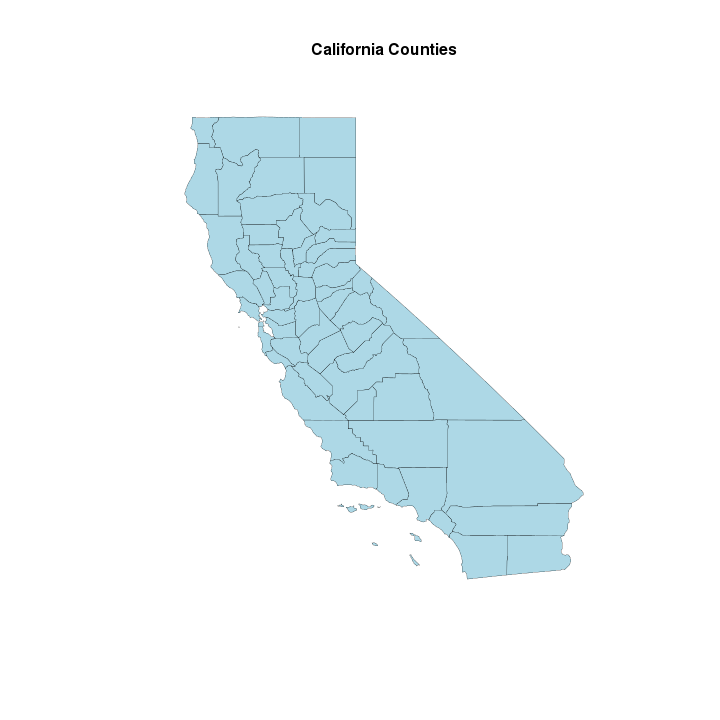

In [3]:
#add new column to dataframe and populate with first two numbers of fips code
inFeatures@data$stcode <- substr(inFeatures@data$atlas_stco, start=1, stop=2)

#select features with a state fips code beginning with...
inFeaturesSubsetA <- inFeatures[grep("06", inFeatures@data$stcode), ]

#plot the state selected
plot(inFeaturesSubsetA,col="lightblue", lwd=.2, main="California Counties",cex.main=.8)

## Generate Neighborhoods for Features¶


Generate neighborhoods for each feature according to the Queen's Criterion. Then test the neighborhoods to see if they are valid. Retain only the features with valid neighborhoods.

In [4]:
#Identify the neighbors of each feature
inFeaturesSubsetA.nb <- poly2nb(inFeaturesSubsetA ,queen=TRUE)

#Select features with at least one neighbor
inFeaturesSubset <- inFeaturesSubsetA[card(inFeaturesSubsetA.nb) >= 1, ]

#Identify the neighbors of each feature having at least one neighbor
inFeaturesSubset.nb <- poly2nb(inFeaturesSubset, queen=TRUE)

#Retrieve neighborhood list
inFeaturesSubset.listb <- nb2listw(inFeaturesSubset.nb,style="B")
inFeaturesSubset.listw <- nb2listw(inFeaturesSubset.nb,style="W")

## Configure Variables to Analyze

In this case, the explanatory variable is set to 'y12_M082_1'.  A binary (0/1) response variable is used to indicate which counties border the coast (1 if they do, 0 or <NA> otherwise). Thus, the original 'coastal' variable needs to be re-worked to change null values to 0.

In [5]:
#set coastal variable = 0 if null
inFeaturesSubset$coastal[is.na(inFeaturesSubset$coastal)] <- 0

#set response variables
YVar <- inFeaturesSubset$coastal

#explanatory variable
Exp1 <- inFeaturesSubset$y12_M082_1

### Plot Observed Response Variables

Visualize the two categories of counties.

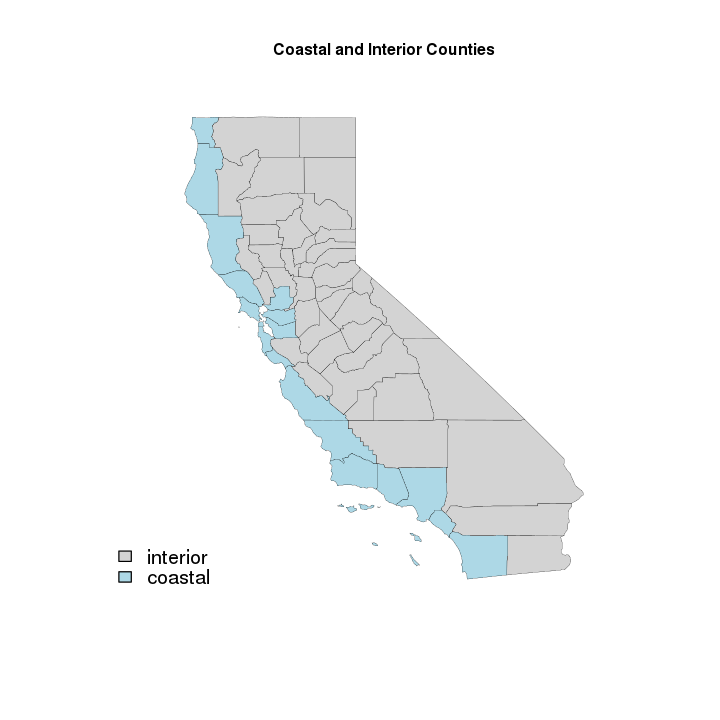

In [6]:
#assign colors to categories
pal <- c("lightgray","lightblue")
cols <- pal[round(inFeaturesSubset@data$coastal)+1]

#plot the variable
plot(inFeaturesSubset, col=cols, lwd=.2,main="Coastal and Interior Counties",cex.main=.8)
leg <- c("interior", "coastal")
legend("bottomleft", fill=pal, legend=leg, bty="n")

### Plot Explanatory Variable

Visualize the geographic distribution of the explanatory variable.

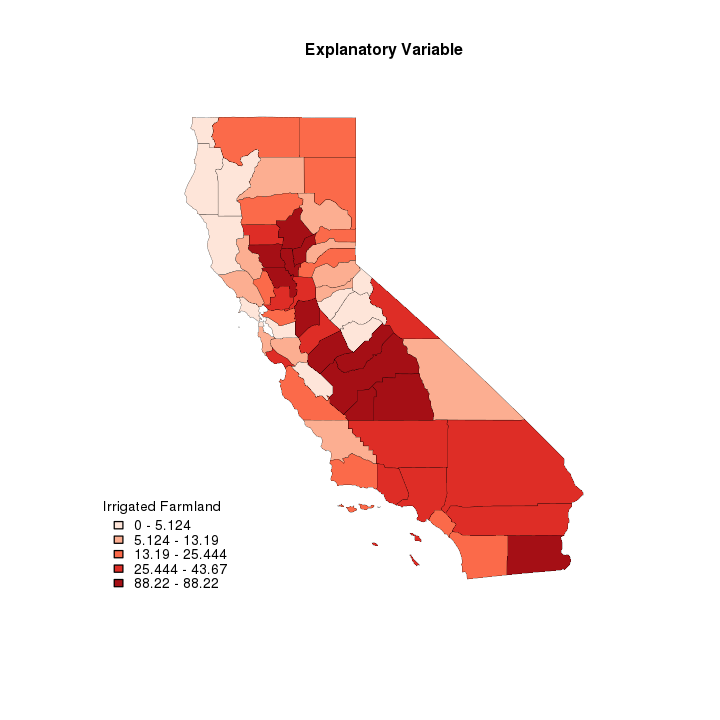

In [7]:
#classify the variable
numcat <- 5
cate <- classIntervals(Exp1, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot values
plot(inFeaturesSubset, col=cols, lwd=.2,main="Explanatory Variable",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Irrigated Farmland",cex=.7)

## Examine Test Statistics for Autocorrelation

Test the explanatory variable for spatial autocorrelation using the Moran and Geary global tests.  

It looks like the Moran test is significant and is greater than zero. Remember what that means?

In [9]:
#run autocorrelation tests
moran.test(YVar, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = 4.1497, p-value = 1.665e-05
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.321578100      -0.017543860       0.006678572 


In [10]:
geary.test(YVar, inFeaturesSubset.listb)


	Geary C test under randomisation

data:  YVar 
weights: inFeaturesSubset.listb 

Geary C statistic standard deviate = 5.1705, p-value = 1.167e-07
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.549003623       1.000000000       0.007608226 


## Standard Logistic Regression 

In order to assess what happens when autocorrelation is not addressed in a model with what happens when it is considered, first let's apply a logistic regression model. This can be done via the glm() function, specifying the family as binomial.

In [11]:
#apply logistic regression
YVar.full <- glm(YVar ~ Exp1, family=binomial)
summary(YVar.full)


Call:
glm(formula = YVar ~ Exp1, family = binomial)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2092  -0.9741  -0.5576   1.1938   1.9490  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  0.07455    0.44060   0.169   0.8656  
Exp1        -0.04189    0.01836  -2.281   0.0225 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 71.848  on 57  degrees of freedom
Residual deviance: 65.226  on 56  degrees of freedom
AIC: 69.226

Number of Fisher Scoring iterations: 4


## Evaluate Autocorrelation in Regression Residuals

Retrieve the residuals from the logistic model. This can be done using the residuals() function (stats library). Next, apply a Moran test for spatial autocorrelation in the residuals.

Note the test is highly significant, indicating the null hypothesis can be rejected. Thus, it is clear that the residuals contain a high level of spatial autocorrelation.

In [12]:
YVar.full.res <- residuals(YVar.full)
moran.test(YVar.full.res, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar.full.res  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = 4.1369, p-value = 1.76e-05
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.320156635      -0.017543860       0.006663794 


## Spatial Filtering

One way to address spatial autocorrelation in a model is to implement what is termed an eigenvector spatial filter. 

The first step is to compute the MBM matrix. Note that matrix B is the spatial weights matrix.

The second step is to generate eigenvalues and eigenvectors that correspond with the dimensions of the input data.

The third step is to do a first cut to weed out eigenvectors that are likely not that relevant for explaining spatial autocorrelation.

In [13]:
#compute MBM
n <- length(inFeaturesSubset)
M <- diag(n) - matrix(1,n,n)/n
B <- listw2mat(inFeaturesSubset.listb)

MBM <- M %*% B %*% M

#Generate Eigenvalues and Eigenvectors
eig <- eigen(MBM, symmetric=T)

#Select most relevant eigenvectors (first cut)
cutThreshold <- 0.25
EV <- as.data.frame( eig$vectors[ ,eig$values/eig$values[1] > cutThreshold])
colnames(EV) <- paste("EV", 1:NCOL(EV),sep="")

### Use Stepwise Regression to Refine Set of Eigenvectors

The next step is to use stepwise regression to select important components of the model related to spatial autocorrelation.  

How many Eigenvectors are selected?  According to the code, which parameters influence how many Eigenvectors are selected?  Hey, what is an Eigenvector anyway?

In [14]:
#specify a logistic regression that includes the eigenvectors
YVar.full <- glm(YVar ~ Exp1 + ., data=EV, family=binomial)
#conduct stepwise regression to spatially filter Eigenvectors, using the full logistic specification as the upper model
YVar.sf <- stepAIC(glm(YVar ~ Exp1, data=EV, family=binomial), scope=list(upper=YVar.full), direction="both",k=2)
coefnm <- names(coef(YVar.sf))

#extract upto exComp components to analyze from final model
formula2 <- c(YVar ~ Exp1)
exComp <- 8
ctit <- 1
formlist <- list()
formula3 <- c()
incnt <- 1
for (ele in coefnm)   {
    if ((ctit <= exComp) && (startsWith(ele,"EV"))) {
        formula2 <- paste(formula2, "+", sep=" ")
        formula2 <- paste(formula2, ele, sep=" ")
        s1 = unlist(strsplit(ele, split='EV', fixed=TRUE))[2]
        formlist[[ctit]] <- as.numeric(s1)
        
        ctit <- ctit + 1
    }
    incnt <- incnt + 1    
}

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Start:  AIC=69.23
YVar ~ Exp1

       Df Deviance    AIC
+ EV6   1   53.558 59.558
+ EV3   1   60.193 66.193
+ EV4   1   62.072 68.072
+ EV5   1   62.979 68.979
<none>      65.226 69.226
+ EV11  1   63.608 69.608
+ EV2   1   63.655 69.655
+ EV13  1   64.292 70.292
+ EV1   1   64.936 70.936
+ EV10  1   64.940 70.940
+ EV14  1   65.014 71.014
+ EV12  1   65.101 71.101
+ EV8   1   65.200 71.200
+ EV9   1   65.214 71.214
+ EV7   1   65.220 71.220
- Exp1  1   71.848 73.848

Step:  AIC=59.56
YVar ~ Exp1 + EV6

       Df Deviance    AIC
+ EV3   1   46.145 54.145
+ EV5   1   48.744 56.744
+ EV4   1   50.533 58.533
+ EV11  1   50.723 58.723
+ EV13  1   51.148 59.148
<none>      53.558 59.558
+ EV2   1   52.004 60.004
+ EV10  1   53.211 61.211
+ EV8   1   53.277 61.277
+ EV12  1   53.415 61.415
+ EV14  1   53.440 61.440
+ EV9   1   53.508 61.508
+ EV7   1   53.536 61.536
+ EV1   1   53.552 61.552
- Exp1  1   60.299 64.299
- EV6   1   65.226 69.226

Step:  AIC=54.15
YVar ~ Exp1 + EV6 + EV3

     

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

       Df Deviance    AIC
+ EV7   1   23.072 39.072
+ EV4   1   27.134 43.134
<none>      29.377 43.377
+ EV2   1   29.008 45.008
+ EV1   1   29.111 45.111
+ EV14  1   29.265 45.265
+ EV12  1   29.277 45.277
+ EV9   1   29.280 45.280
+ EV8   1   29.325 45.325
+ EV10  1   29.376 45.376
- EV13  1   35.271 47.271
- EV11  1   37.269 49.269
- EV3   1   37.353 49.353
- Exp1  1   38.013 50.013
- EV5   1   41.332 53.332
- EV6   1   56.298 68.298


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=39.07
YVar ~ Exp1 + EV6 + EV3 + EV5 + EV11 + EV13 + EV7



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

       Df Deviance    AIC
+ EV4   1   21.044 39.044
<none>      23.072 39.072
+ EV1   1   22.147 40.147
+ EV2   1   22.398 40.398
+ EV8   1   22.857 40.857
+ EV10  1   22.883 40.883
+ EV14  1   22.974 40.974
+ EV9   1   23.059 41.059
+ EV12  1   23.066 41.066
- EV7   1   29.377 43.377
- Exp1  1   31.086 45.086
- EV13  1   32.659 46.659
- EV3   1   35.895 49.895
- EV11  1   36.256 50.256
- EV5   1   41.186 55.186
- EV6   1   56.252 70.252


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=39.04
YVar ~ Exp1 + EV6 + EV3 + EV5 + EV11 + EV13 + EV7 + EV4



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

       Df Deviance    AIC
<none>      21.044 39.044
- EV4   1   23.072 39.072
+ EV9   1   20.326 40.326
+ EV2   1   20.463 40.463
+ EV1   1   20.895 40.895
+ EV14  1   20.978 40.978
+ EV8   1   20.986 40.986
+ EV10  1   20.993 40.993
+ EV12  1   21.043 41.043
- EV7   1   27.134 43.134
- Exp1  1   27.951 43.951
- EV13  1   29.744 45.744
- EV11  1   32.928 48.928
- EV3   1   34.524 50.524
- EV5   1   38.997 54.997
- EV6   1   52.748 68.748


### Given the selected Eigenvectors, run the spatially filtered logistic model

Now that the major eigenvectors have been selected, apply them to the logistic model.

In [15]:
#populate model with selected Eigenvectors
YVar.sf <- glm(formula2, data=EV, family=binomial)
summary(YVar.sf)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = formula2, family = binomial, data = EV)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.94017  -0.10034  -0.00013   0.10142   1.72053  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)  -4.49007    2.41938  -1.856   0.0635 .
Exp1         -0.11141    0.05847  -1.905   0.0567 .
EV6          50.23753   19.89058   2.526   0.0115 *
EV3         -24.25084    9.92919  -2.442   0.0146 *
EV5          35.07741   15.66496   2.239   0.0251 *
EV11        -30.38821   14.78919  -2.055   0.0399 *
EV13        -18.49919    8.85166  -2.090   0.0366 *
EV7         -14.83109    8.23364  -1.801   0.0717 .
EV4          -5.86919    4.40220  -1.333   0.1825  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 71.848  on 57  degrees of freedom
Residual deviance: 21.044  on 49  degrees of freedom
AIC: 39.044

Number of Fisher Scoring iterations

## Evaluate Autocorrelation of Spatial Filter Residuals

Examine the residuals obtained from the spatially filtered specification. Apply the Moran test statistic to evaluate the presence of spatial autocorrelation in the residuals. 

Note that the Moran test is not significant, indicating that the null hypothesis cannot be rejected. Thus, significant spatial autocorrelation among the residuals no longer exists.

In [16]:
#extract residuals
YVar.sf.res <- round(residuals(YVar.sf, type="response"))

#analyze autocorrelation test statistics for residuals
moran.test(YVar.sf.res, inFeaturesSubset.listb)
geary.test(YVar.sf.res, inFeaturesSubset.listb)


	Moran I test under randomisation

data:  YVar.sf.res  
weights: inFeaturesSubset.listb  

Moran I statistic standard deviate = -0.69463, p-value = 0.7564
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.070048309      -0.017543860       0.005713308 



	Geary C test under randomisation

data:  YVar.sf.res 
weights: inFeaturesSubset.listb 

Geary C statistic standard deviate = -0.22804, p-value = 0.5902
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
       1.03260870        1.00000000        0.02044711 


### Plot Spatial Filtered Fitted Values

The fitted values (the difference between the reponse variable and the residuals) from the spatially filtered model are output to a field named 'fitted' associated with the SAR output. Let's evaluate the geographic distribution of these fitted values.Notice that the fitted values all fall within the range [0,1]!

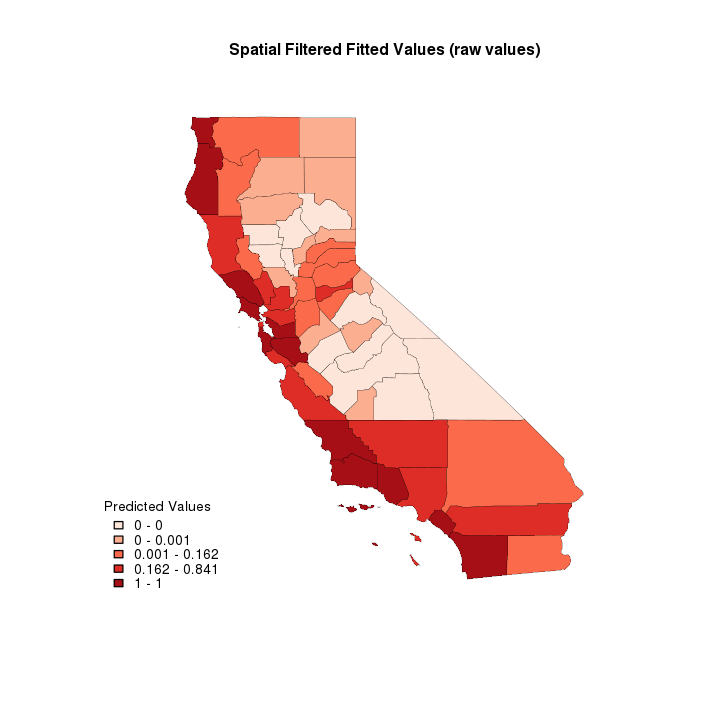

In [17]:
#classify the variable
numcat <- 5
cate <- classIntervals(YVar.sf$fitted, numcat, style="quantile")

#assign colors to categories
pal <- brewer.pal(numcat,"Reds")
cols <- findColours(cate,pal)

#plot the variable
plot(inFeaturesSubset, col=cols, lwd=.2,main="Spatial Filtered Fitted Values (raw values)",cex.main=.8)
brks <- round(cate$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Predicted Values",cex=.7)

### Round the fitted values and visualize the predicted values

Given the fitted values now fall between 0 and 1, let's round them so they are either 0 or 1...just as the response variables were originally.

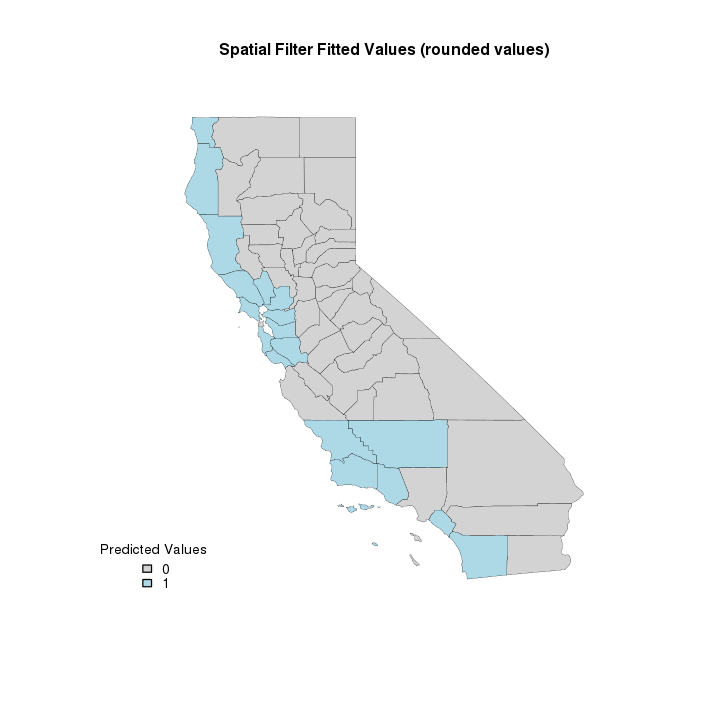

In [18]:
#assign colors to categories
pal <- c("lightgray","lightblue")
cols <- pal[round(YVar.sf$fitted)+1]

#plot the variable
plot(inFeaturesSubset, col=cols, lwd=.2,main="Spatial Filter Fitted Values (rounded values)",cex.main=.8)
leg <- c("0", "1")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="Predicted Values",cex=.7)